# Podstawowe metody klasyfikacji - ciąg dalszy: drzewa decyzyjne i łączenie modeli

<img src="../mum_figures/ml_map.png" width="100%"/>

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set(font_scale=2.5)

In [4]:
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing

In [7]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression, make_blobs
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [8]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

# Drzewa decyzyjne

* granice decyzyjne można utworzyć w sposób __hierarchiczny__
  * struktura drzewa
  * sekwencja testów o binarnych odpowiedziach __tak__/__nie__
  * każdy test jest wykonywany na __pojedynczym__ atrybucie
    * szybka budowa
  * __binarne drzewa klasyfikacjne__
  * __drzewa regresji i klasyfikacji__ (_classification and regression trees CART_, Breiman od 1984)
  * podobne modele ID3, C4.5, C5.0 (Quinlan, od 1986)
  * rozwiązania wynikające z drzew są łatwe do interpretacji
    * przydatne w systemach medycznych i innych systemach ekspertowych, prosta ekstrakcja cech

### Klasyfikacja danych astronomicznych
* klasyfikacja gwiazdy stałe / typ pulsujących gwiazd zmiennych (RR Lyrae)
  * okres od $0.2$ do $1.2$ dnia
* obserwacje z teleskopu SDSS
* $92 658$ gwiazd niezmiennych / 483 pulsujące
* opisane w przestrzeni kolor-kolor
  * $0.70<u-g<1.35$
  * $-0.15<g-r<0.40$
  * $-0.15<r-i<0.22$
  * $-0.21<i-z<0.25$

<img src="../mum_figures/ll_lyrae.jpg" width="100%"/>

<img src="../mum_figures/ll_lyrae_dt.png" width="80%"/>

<img src="../mum_figures/ll_lyrae_dt_results.png" width="90%"/>

* podział przestrzeni wejściowej hiper-płaszczyznami __równoległymi__ do osi układu współrzędnych
  * równoległość może okazać się problemem
  * wybór atrybutu do wykonania testu
  * wybór wartości dzielącej
  * wykonanie testu i podział zbioru danych
  * powtórka aż do siągnięcia warunku końca __niezależnie__ dla każdego z poddrzew
    * wszystkie przykłady (albo znaczna większość) w jednym węźle należą do jednej klasy
    * liczba przykładów w węzłach poniżej ustalonego minimum
    * liczba poziomów drzewa powyżej ustalonego maksimum
  * dla każdego podziału jest w zasadzie osobny model
  * klasyfikacja przykładów
    * wykonanie testów według drzewa i wyników
    * klasyfikacja według liścia w którym przykład wyląduje
      * każdy liść związany z jedną etykietą klasy 
        * głosowanie według przykładów w lisciu w trakcie uczenia
      
      
      
* __podstawowe pytania__
  * najlepszy sposób wyboru testów?
  * kiedy przerwać tworzenie testów w danym poddrzewie?
  * jak związać liść z odpowiedzią?

## Kryterium podziału węzłów
* test $$x_i<t$$ 
  * dla danych dyskretnych odpowiada to wyborowi pewnego podzbioru wartości
  * każdy test dzieli przykłady $X$ na __dwa rozłączne__ podzbiory $X_{<t}$ i $X_{>t}$
  * założenie
  $$\boxed{
  \text{podział generuje podzbiory}\; X_{<t}\; \text{ i }\; X_{>t} \text{ bardziej homogeniczne niż ich suma}
  \;}$$
    * __homogeniczne__ bardziej spójne jeśli chodzi o klasyfikację
    * przykłady w podzbiorach __przykładów__ częściej należą do podzbioru __klas__
    * zmierzyć __zanieczyszczenie__ (impurity, contamination) zbioru _przed podziałem_,
    * wybrać test, dla którego oczekiwana czystość w podzbiorach _po podziale_ zwiększy się w największym stopniu
* możliwe testy
  * __entropia__ $$\boxed{E(t)=-\sum_{k=1}^KP(c_k\mid t)\,\log_2P(c_k\mid t)\;}$$
    wykorzystywana w drzewach klasyfikacji ID3, C4.5, C5.0
    * __największa__ impurity jest gdy prawdopodobieństwa wszystkich klas są równe
  * __najmniejsza__ gdy prawdopodobieństwo dla jednej klasy wynosi $1$
    * __entropia ważona po podziale__ 
    $$E(<t,>t)=\frac{N_{<t}}{N_t}E(<t)+\frac{N_{>t}}{N_t}E(>t),$$
    gdzie $N_{<t}/N_t$ to liczba przykładów w poddrzewie dla wyniku $<t$
    * wybrać test którego __zysk informacyjny__ (_infromation gain_) 
    $$\boxed{IG(<t,>t)=E(t)-E(<t,>t)\;}$$ 
    jest __największy__ 
    $$\boxed{IG(x\mid t)=\\E(t)-\underset{x}{\arg\max}\left[\frac{N(x\mid x<s)}{N}E(x\mid x<t)-\frac{N(x\mid x\geq s)}{N}E(x\mid x\geq t)\right]\;\;\;\;\;}$$
    
      
      
      
* __indeks Giniego__ (_Gini impurity_)
    $$\boxed{I(t)=\sum_{k=1}^KP(c_k\mid t)(1-P(c_k\mid t))\;}$$
    wykorzystywany w drzewach regresji
  * ekstrema w tych samych miejscach
  * bardziej wyraźne maksimum
* __błąd klasyfikacji__ $$1-P(c_k\mid t)$$
  * którą z funkcji wybrać?
* entropia i Gini są różniczkowalne i bardziej czułe na zmianę liczby przykładów


> UWAGA: __współczynnik Giniego__ (_Gini coefficient_) wykorzystywany jako miara nierównomiernego (koncentracji) podziału dóbr, to _inna_ miara!

> W USA ok. 0.45, w Polsce ok. 0.3 (mniej więcej w połowie skali w UE).

In [9]:
def entropy_gini():
    def entropy(x):
        return 0.5 * (-x * np.log2(x) - (1 - x) * np.log2(1 - x))
    def gini(x):
        return 2.0 * x * (1.0 - x) 
    def misclassification(x):
        return np.minimum(1 - x, x)

    fig, ax = plt.subplots(figsize=(18, 10))
    x = np.linspace(0.0001, 0.999, 1000)
    ax.plot(x, entropy(x), label='Entropia')
    ax.plot(x, gini(x), label='Indeks Giniego')
    ax.plot(x, misclassification(x), label='Błąd klasyfikacji')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([0.0, 0.51])
    ax.legend(loc='best')

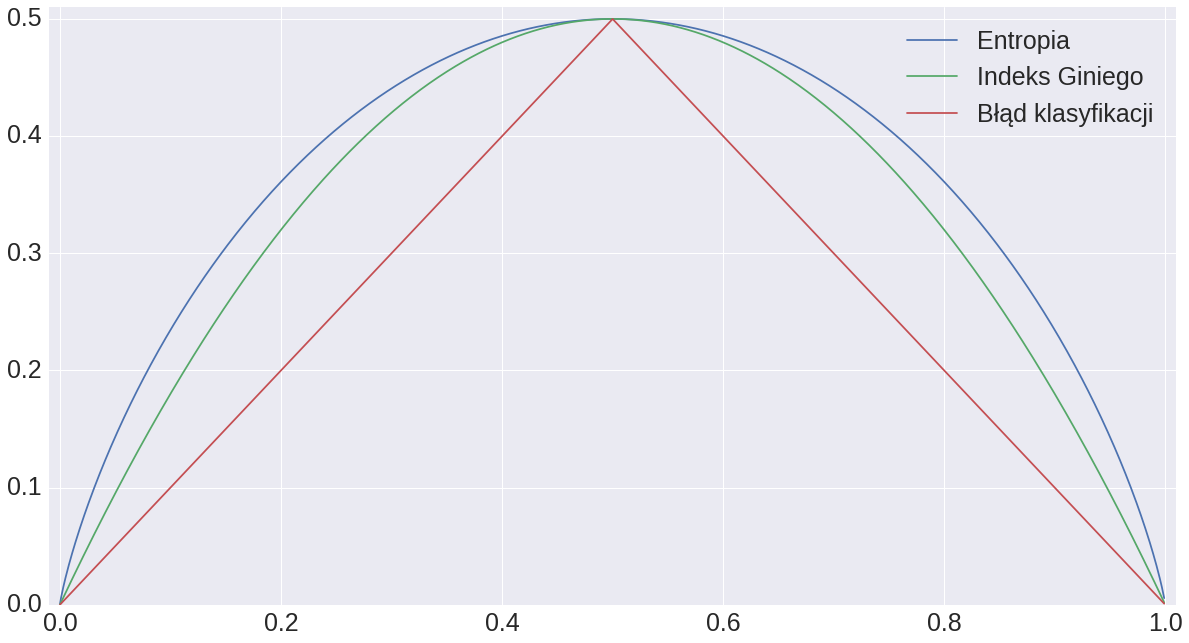

In [10]:
entropy_gini()

### Budowa drzewa
* znalezienie optymalnego punktu podziału jest obliczeniowo trudne
  * dla zmiennych dyskretnych konieczne jest określenie wszystkich możliwych podziałów na podzbiory wartości
  * dla atrybutów ciągłych konieczne jest znalezienie progu
    * posortować wartości dla danego atrybutu
    * wygenerować punkty podziału __pośrodku__ pomiedzy kolejnymi punktami
    * obliczyć nieczystość zbiorów dla każdego progu 

## Kryterium stopu
* gdy drzewa przestaje rosnąć (węzły są całkowicie homogeniczne)
* gdy zysk informacyjny jest poniżej ustalonego progu (przykłady z jednej klasy znacznie przeważają w liściach)
* gdy liczności przykładów w liściach spadają poniżej ustalonego progu
  * dalszy podział nie ma sensu, ponieważ model będzie źle generalizował

## Przypisanie węzłów
* zwykle reguła większościowa

## Ograniczanie głębokości i obcinanie (pruning) drzew
* zwiększanie złożonosci prowadzi do nadmiernego dopasowania
  * wraz ze wzrostem głębokości maleje błąd
  * przy zbyt dużych głębokościach drzewa odwzorowywują __szum__ w danych
  * konieczne użycie metod walidacji krzyżowej
    * wyznacznikiem maksymalnej głębokości może być gdy __błąd walidacji _odchodzi_ od spadającego błędu na danych trenujących__


* popularną metodą jest
  * zbudować drzewo pełne
    * często pojedyncze podziały dają bardzo niewielki zysk informacyjny
    * jednak zysk po szeregu podziałów jest już istotny
    * stąd może się opłacać budowa pełnego drzewa
  * hierarchicznie __łączyć__ liście używając pewnego kryterium stopu mogą być
    * oceniając prawdopodobieństwo błędu przypidania
    * wykorzystując odpowiedni zbiór walidacyjny
    * biorąc pod uwagę miarę złożoności modelu
  * do obcinania drzewa __najlepiej__ użyć __danych walidujących__

## Zadania i problemy

### zmienne nominalne
* dla $M$ wartości zmiennej jest $2^{M-1}-1$ możliwych podziałow na dwie grupy
* zadanie jest prostsze w problemie binarnym
  * posortować wartości według prawdopodobieństwa przypadania do klasy 1
  * teraz rozwiązać zadania jakby atrybut był uporządkowany
    * dowód jest calkiem nietrywialny
* dla wieloklasowego problemu nie ma prostych rozwiązań
  * tylko przybliżenia, heurezy
  
### brakujące atrybuty
* opuszczanie przykładów z brakującymi atrybutami
  * zwykle zdecydowanie osłabia zbiór uczący
* wypełnienie wartości brakujących
  * średnią (czy medianą) z wszystkich przykładów
    * może wprowadzać fałszywe wartości
  * dla zmiennych kategorycznych wprowadzenie wartości __missing__
    * pozwoli na wykrycie reguł zachowania
  * wprowadzenie __zmiennych zastępczych__
    * przy wyborze testów wykorzystywane są przykłady ze zmiennymi pełnymi
    * dla danych brakujących tworzona jest lista predyktorów __zastępczych__
      * pierwszy najlepiej udający podział dla danych oryginalnych
      * drugi najlepszy, itd.

      
      
### czemu podziały binarne?
* podział na większą liczbę skróciłby drzewo
* jednak liczba przykładów w klasie zbyt szybko by spadła


### podziały dla kombinacji liniowych atrybutów
* może wspomóc uczenie
* osłabia interpretowalność

## Cechy drzew decyzyjnych
* łatwa obsługa zbiorów z różnymi typami danych (ciągłymi, dyskretnymi, nominalnymi)
* prosta obsluga przykładów z danymi brakującymi
  * dane mogą być brakujące także gdy są kosztowne
* łatwa interpretowalność
  * słaba stabilność obniża jakość interpretowalności
* __słabsza__ generalizacja w porównaniu z innymi modelami
* podziały wzdłuż współrzędnych mogą być bardzo nieoptymalne
  * wykluczają przecięcia "na ukos"
  * możliwy preprocessing danych dla ich odpowiedniego obrotu, np. PCA
    * może osłabić interpretowalność


* __drzewa są mało stabilne__
  * budowa drzewa zależy w dużym stopniu od postaci zbioru uczącego
  * niewielka jego zmiana może spowodować dużą zmianę drzewa i predykcji
    * podejścia __bagging__ i __random forests__
    
    
* możliwa budowa __drzew regresji__ 
$$\boxed{\hat{f}(x)=\sum_{R_i}\overline{y}_{i}I(x\in{}R_i)\;}$$
  * budowa drzewa podobna
    * miarą odpowiadającą czystości węzłów jest suma kwadratów residuuów w węźle
  * wartością wyjściową liścia jest średnia przykładów w nim
    * użycie $\overline{y}_i$ minimalizuje błąd średniokwadratowy
    * wyjściowa funkcja $\hat{f}$ jest schodkowa
  * ewentualnie prosta regresja
    * zwykle trudne ze względu na małą liczbę przykładów
    
    
Drzewa decyzyjne w czystej postaci __nie są__ wystarczająco dobrymi klasyfikatorami

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
def decision_tree_classifier(n_samples=100, centers=2, min_samples_leaf=1,
                       max_depth=None, odds='odds'):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=1.0)
    cls = DecisionTreeClassifier(criterion='gini',max_features='auto',
                                 max_depth=max_depth, 
                                 min_samples_leaf=min_samples_leaf)
    cls.fit(X, y)
    
    fig_lines = (centers + 2) / 2
    fig, ax = plt.subplots(fig_lines, 2, figsize=(18, fig_lines * 8))

    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax[0, 0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax[0, 0].set_xlim(xx.min(), xx.max())
    ax[0, 0].set_ylim(yy.min(), yy.max())
    ax[0, 0].set_xticks(())
    ax[0, 0].set_yticks(())
    
    # odds lub log-odds dla poszczegolnych klas
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    for n in range(centers):
        if odds == 'odds':
            Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        elif odds == 'log':
            Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        Z = Z.reshape(xx.shape)
        row = (n + 1) / 2; col = (n + 1) % 2
        ax[row, col].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        ax[row, col].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                             cmap=plt.cm.Paired)
        ax[row, col].set_xlim(xx.min(), xx.max())
        ax[row, col].set_ylim(yy.min(), yy.max())
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
    
    plt.tight_layout()

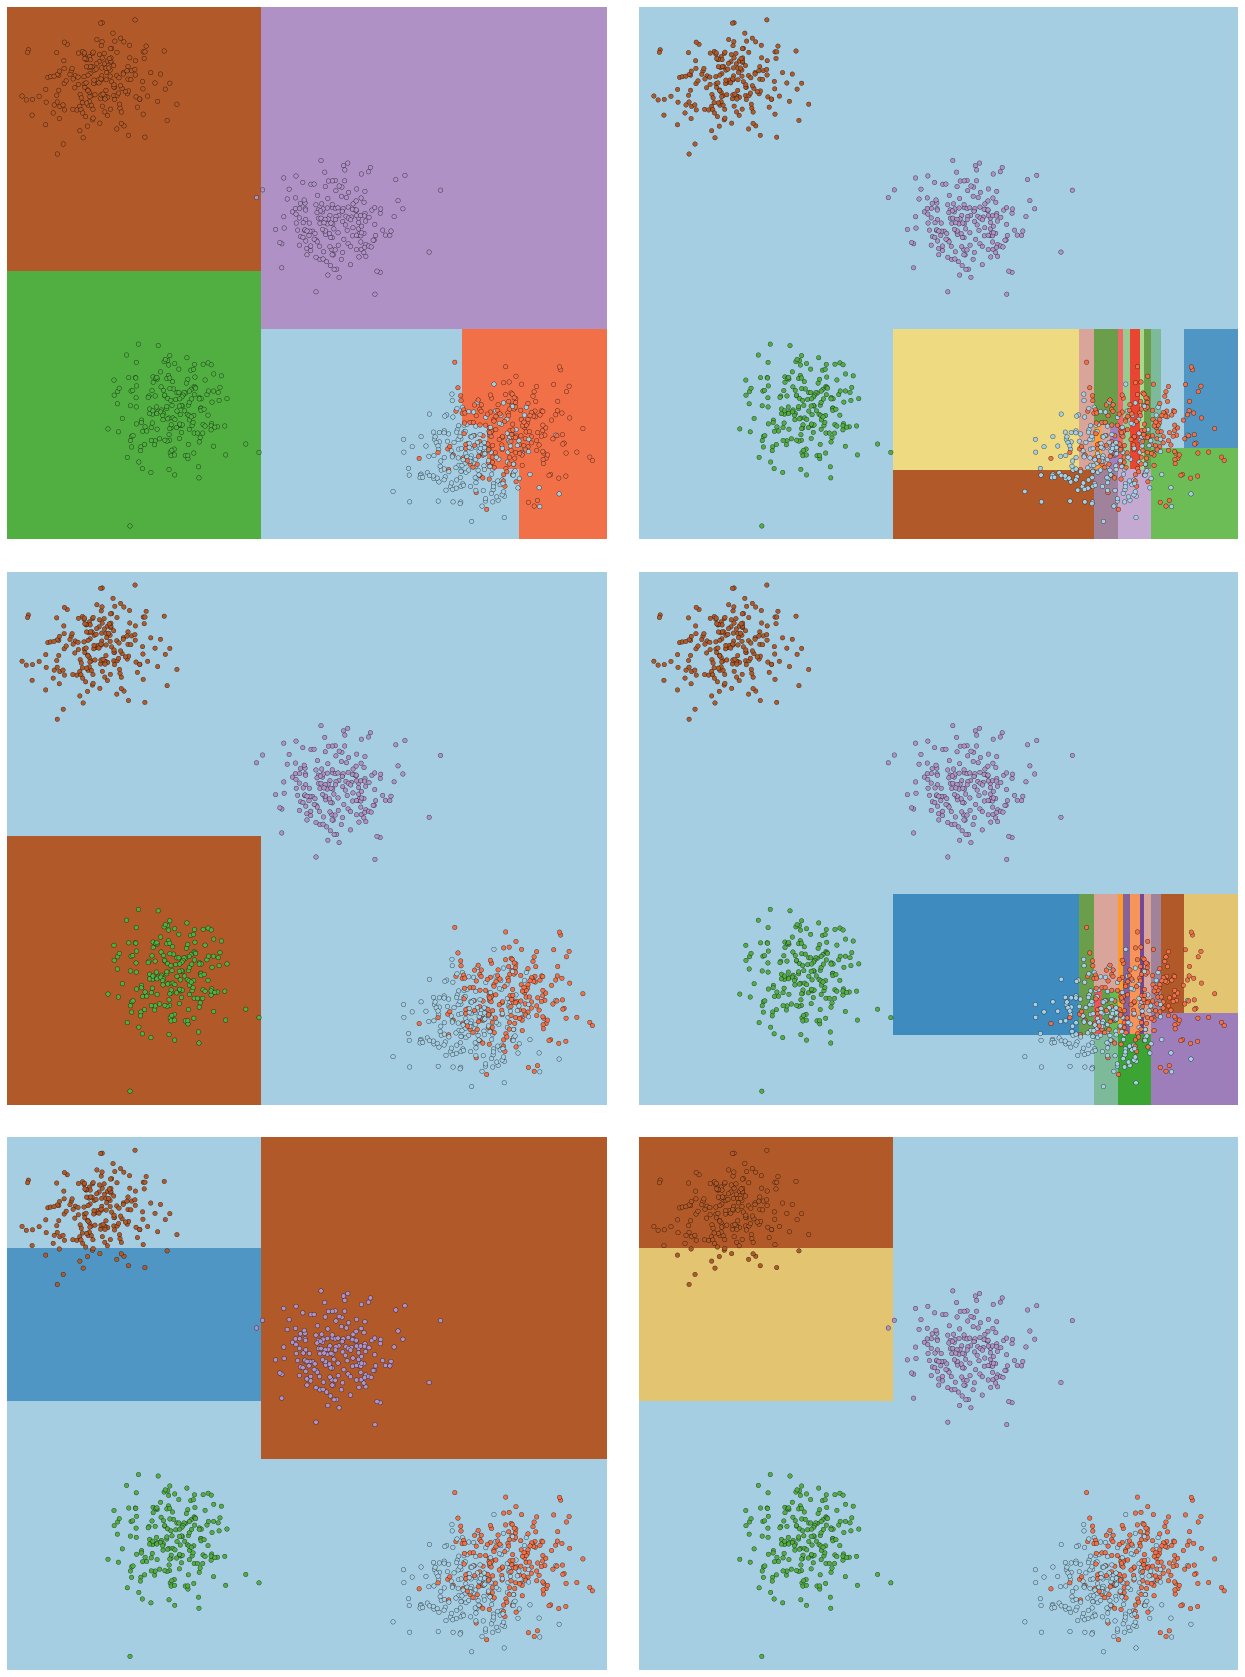

In [15]:
decision_tree_classifier(n_samples=1000, centers=5, min_samples_leaf=17, odds='odds')

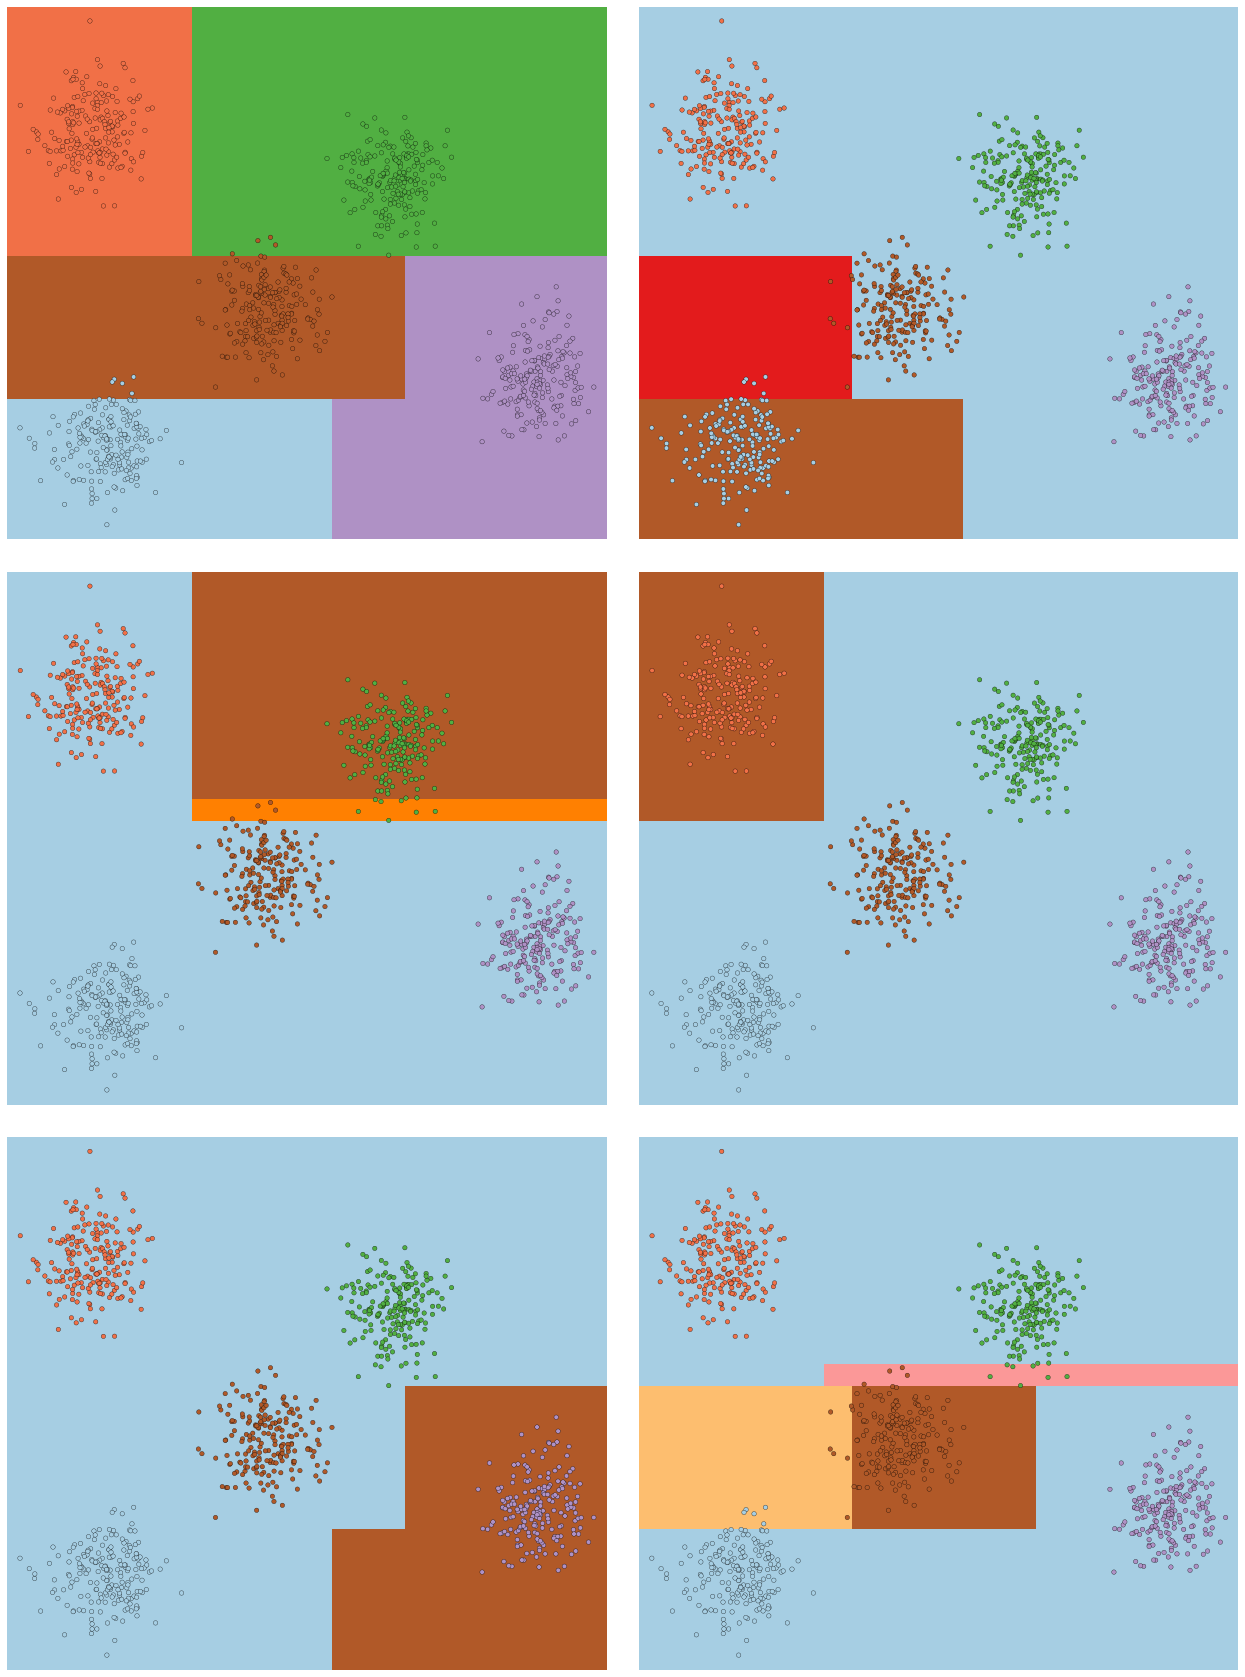

In [16]:
decision_tree_classifier(n_samples=1000, centers=5, min_samples_leaf=11, odds='odds')

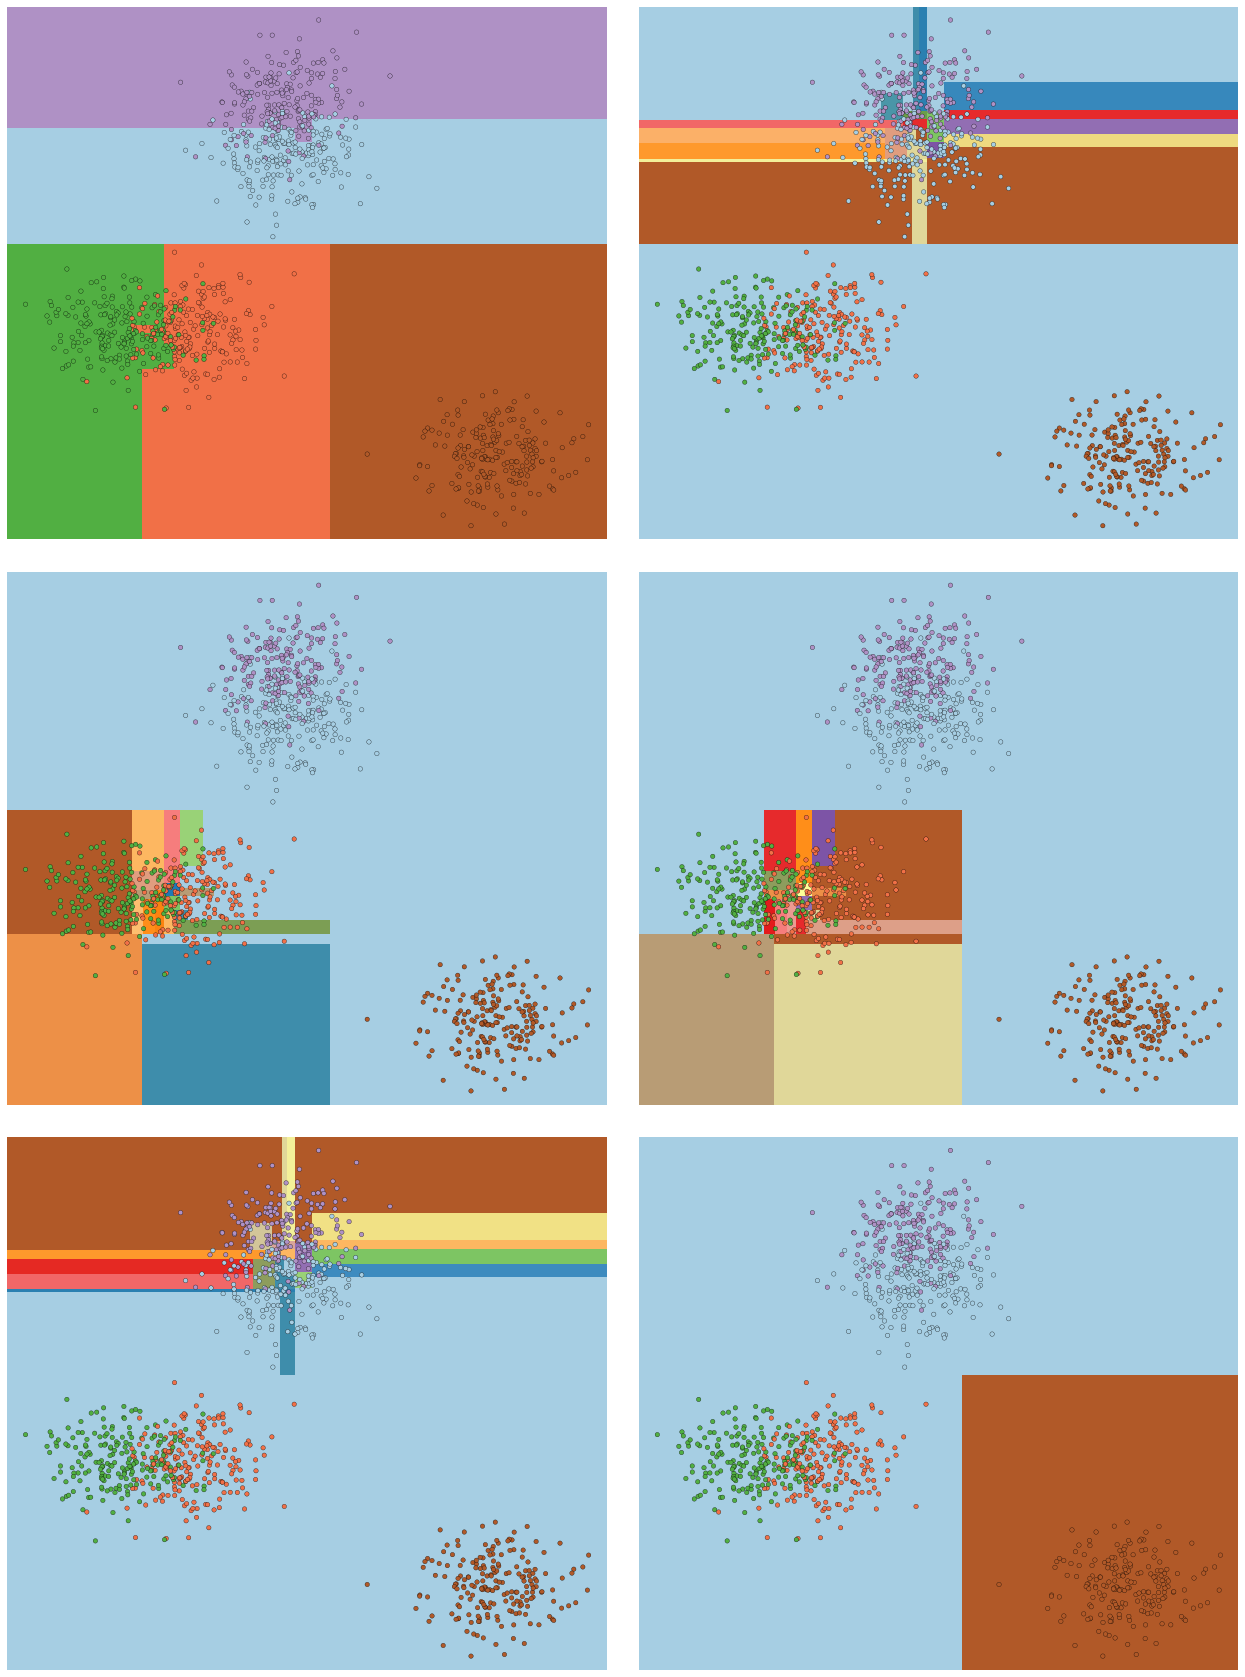

In [17]:
decision_tree_classifier(n_samples=1000, centers=5, min_samples_leaf=9, odds='odds')

## Bagging (bootstrap aggregation)
* rodzaj modelu __ensemble__

* losowanie zbiorów bootstrap pozwala na uzyskanie __wielu różnych zbiorów danych o podobnym rozkładzie__
* __estymator typu _bagging___ jest zdefiniowany jako 
$$\boxed{
\hat{f}_{bag}(x)=\frac{1}{B}\sum_{b=1}^B\hat{f}^{*b}(x)
\;}$$


* jeśli $\hat{f}$ nauczona na całym zbiorze jest liniowa, to estymator bagging $\hat{f}_{bag}$ będzie go dobrze przybliżał
  * jeśli $\hat{f}$ jest nieliniowa lub silnie zależna od danych, to będą się różnić
    * poszczególne $\hat{f}_b()$ będą popełniały błędy w __różnych__ częściach zbioru uczącego
  * estymator bagging dla drzew regresji da dobrze wygładzone wyniki

* niech modelem będzie K-klasowy klasyfikator zwracający K-wymiarowy wektor 
$$[p_1(x), p_2(x),\dots,p_K(x)]$$
wtedy klasyfikator bagging da odpowiedź przez __głosowanie__
$$\boxed{\hat{G}_{bag}(x)=\underset{k}{\arg\max}\,\hat{f}_{bag}(x)\;}$$
* jesli potrzebne jest _prawdopodobieństwo_ klasy
  * właściwe jest raczej uśrednienie wyników z poszczególnych klasyfikatorów
  * wartości zwracane przez klasyfikatory powinny być intepretowalne jako prawdopodobieństwa
  
  
* analiza podobna do analizy błędu jako sumy biasu i wariancji pokazuje, że
  * błąd z wykorzystaniem estymatora bagging jest niższy niż dla estymatora zbudowanego na całym zbiorze danych
  * dla problemów klasyfikacji bias i wariancja nie mogą być sumowane
    * łączenie _dobrych_ klasyfikatorów daje lepsze wyniki
    * jednak łączenie _złego_ klasyfikatora może pogorszyć wyniki!
    * jednak tzw. __słabe__ klasyfikatory bardzo dużo zyskują na składaniu

In [18]:
def bagging_classsifier_score(centers=3, n_samples=100, max_trees=20):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=2.0)
    fig, ax = plt.subplots(figsize=(18, 16))
    cv_no = 10
    
    scores = np.zeros((max_trees, 2))
    n_range = range(1, max_trees)
    for tr in n_range:
        # we create an instance of Bagging Classifier and fit the data.
        clf = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=3), 
                                n_estimators=tr)
        sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
        scores[tr, :] = [np.mean(sc), np.var(sc)]
    # print scores
    ax.errorbar(n_range, scores[1:, 0], scores[1:, 1])
    best_ind = np.argmax(scores[:, 0])
    print('Najlepszy wynik dla {} drzew, {:.4f} +- {:.5f}'.format(best_ind, scores[best_ind, 0], 
                                             scores[best_ind, 1]))
    ax.set_xlabel('Liczba użytych drzew decyzyjnych', fontsize=16)
    ax.set_ylabel("Poprawność klasyfikacji", fontsize=16)
    least = np.min(scores[1:, 0] - scores[1:, 1])
    maxi = np.max(scores[1:, 0] + scores[1:, 1])
    ax.set_ylim([least - 0.005, maxi + 0.005])
    ax.grid()

Najlepszy wynik dla 36 drzew, 0.5267 +- 0.00259


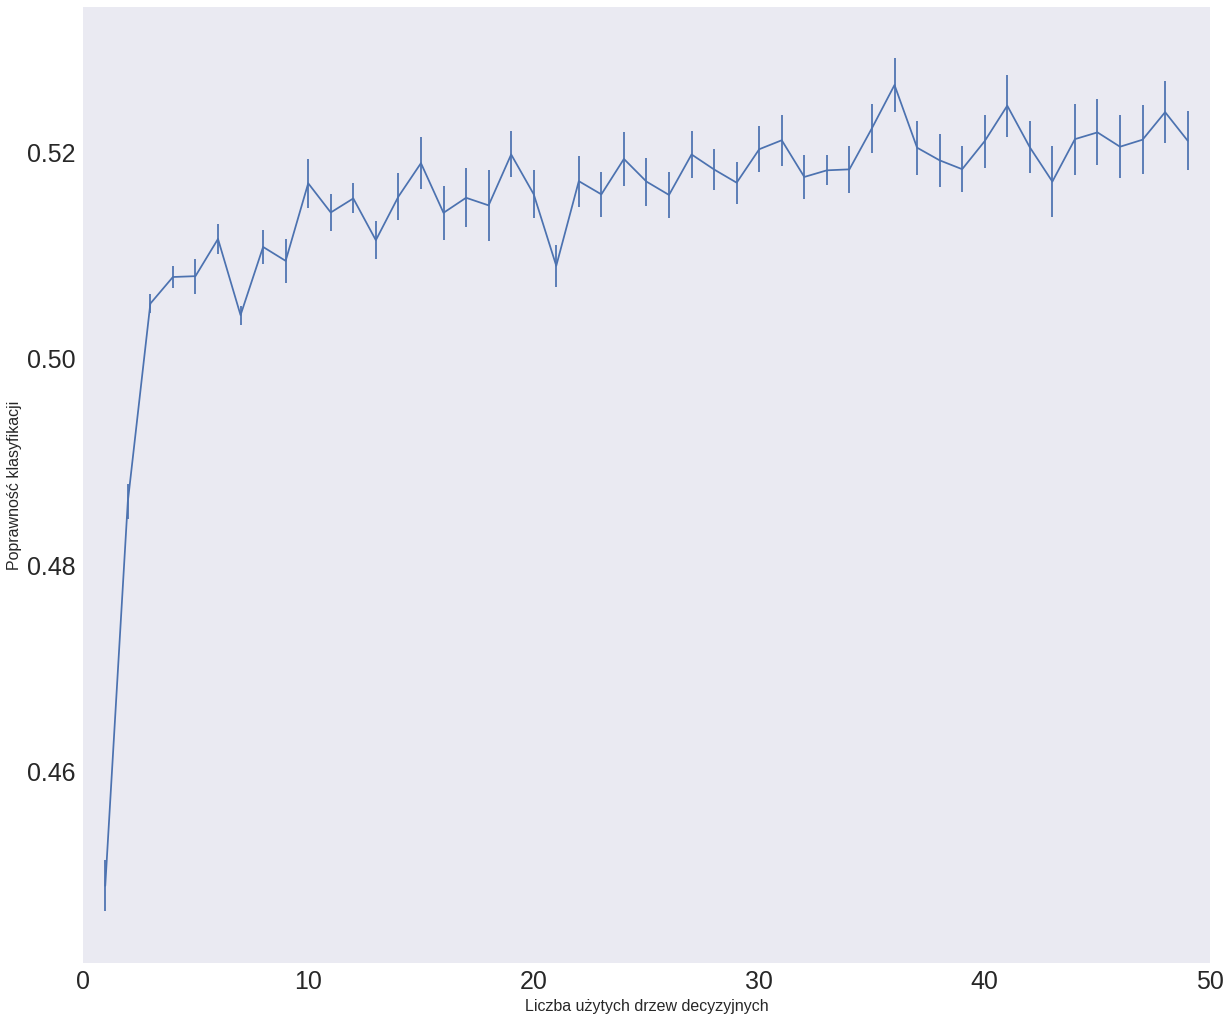

In [83]:
bagging_classsifier_score(n_samples=1500, centers=9, max_trees=50)

## Lasy drzew losowych

* __bagging__ okazało się bardzo dobrym algorytmem
* przez długi czas przejeło podejście __boosting__
* Breiman zaproponował __lasy drzew losowych__
  * duża liczb __nieskorelowanych drzew__ uśrednionych na końcu
  
  
* idea: __uśrednić__ dużą liczbę drzew zawierających dużo szumu
  * drzewa decyzyjne nadmiernie dopasowują przy głębokich drzewach
  * podział wzdłuż osi układu współrzędnych zwykle nie odpowiada problemowi
  * uśrednianie i losowanie poprawia te problemy

### Budowa lasu drzew losowych

1. for b in range(B):
  1. wylosuj zbiór typu bootstrap $Z^{*b}$
  2. buduj drzewo losowe ze zbioru bootstrap powtarzając do osiągnięcia warunku stopu
    1. wybierz __losowo__ $m$ atrybutów spośród $p$ dostępnych
      * dla klasyfikacji typowo $m\approx\lfloor\sqrt{p}\rfloor$
      * dla regresji $m\approx\lfloor p/3\rfloor$
      * zwykle $p$ jest meta-parametrem
    2. spośród wybranych wybierz __najistotnijeszy__
    3. rozdziel węzeł
    
    
### Odpowiedż
* dla regresji jako średnią
* dla klasyfikacji przez głosowanie większościowe

### Jak to działa

* wszystkie drzewa mają identyczny bias i są bardzo zaszumione
* uśrednianie modeli redukuje wariancję


* istotna jest zależność między modelami
  * wszystkie modele mają taki sam rozkład i wariancję $\sigma^2$
    * uśrednione $B$ modeli ma wariancję $\sigma^2/B$
  * niech modele mają średnią korelację między sobą $\rho$
    * korelacja jest __dodatnia__
  * wariancja uśrednionych modeli ma postać $$\rho\sigma^2+\frac{1-\rho}{B}\sigma^2$$
    * jeśli  liczba modeli rośnie, to drugi skladnik zanika
    * wartość __korelacji__ modeli staje się __istotnym czynnikiem__
      * losowy wybór atrybutów __minimalizuje__ korelację między modelami!
      
* z takiego rozrzucania danych najbardziej korzystają klasyfikatory nieliniowe, takie jak drzewa
  

In [19]:
def random_forest_score(centers=3, n_samples=100, max_trees=20):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=2.0)
    fig, ax = plt.subplots(figsize=(18, 16))
    cv_no = 10
    
    scores = np.zeros((max_trees, 2))
    n_range = range(1, max_trees)
    for tr in n_range:
        # we create an instance of Random Forest Classifier and fit the data.
        clf = RandomForestClassifier(n_estimators=tr)
        sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
        scores[tr, :] = [np.mean(sc), np.var(sc)]
    # print scores
    ax.errorbar(n_range, scores[1:, 0], scores[1:, 1])
    ax.plot(n_range, scores[1:, 0], c='red', lw=2)
    best_ind = np.argmax(scores[:, 0])
    print('Najlepszy wynik dla {} drzew, {:.4f} +- {:.5f}'.format(best_ind, scores[best_ind, 0], 
                                             scores[best_ind, 1]))
    ax.set_xlabel('Liczba uzytych drzew decyzyjnych', fontsize=16)
    ax.set_ylabel("Poprawnosc klasyfikacji", fontsize=16)
    least = np.min(scores[1:, 0] - scores[1:, 1])
    maxi = np.max(scores[1:, 0] + scores[1:, 1])
    ax.set_ylim([least - 0.005, maxi + 0.005])
    ax.grid()

Najlepszy wynik dla 15 drzew, 0.6675 +- 0.00119


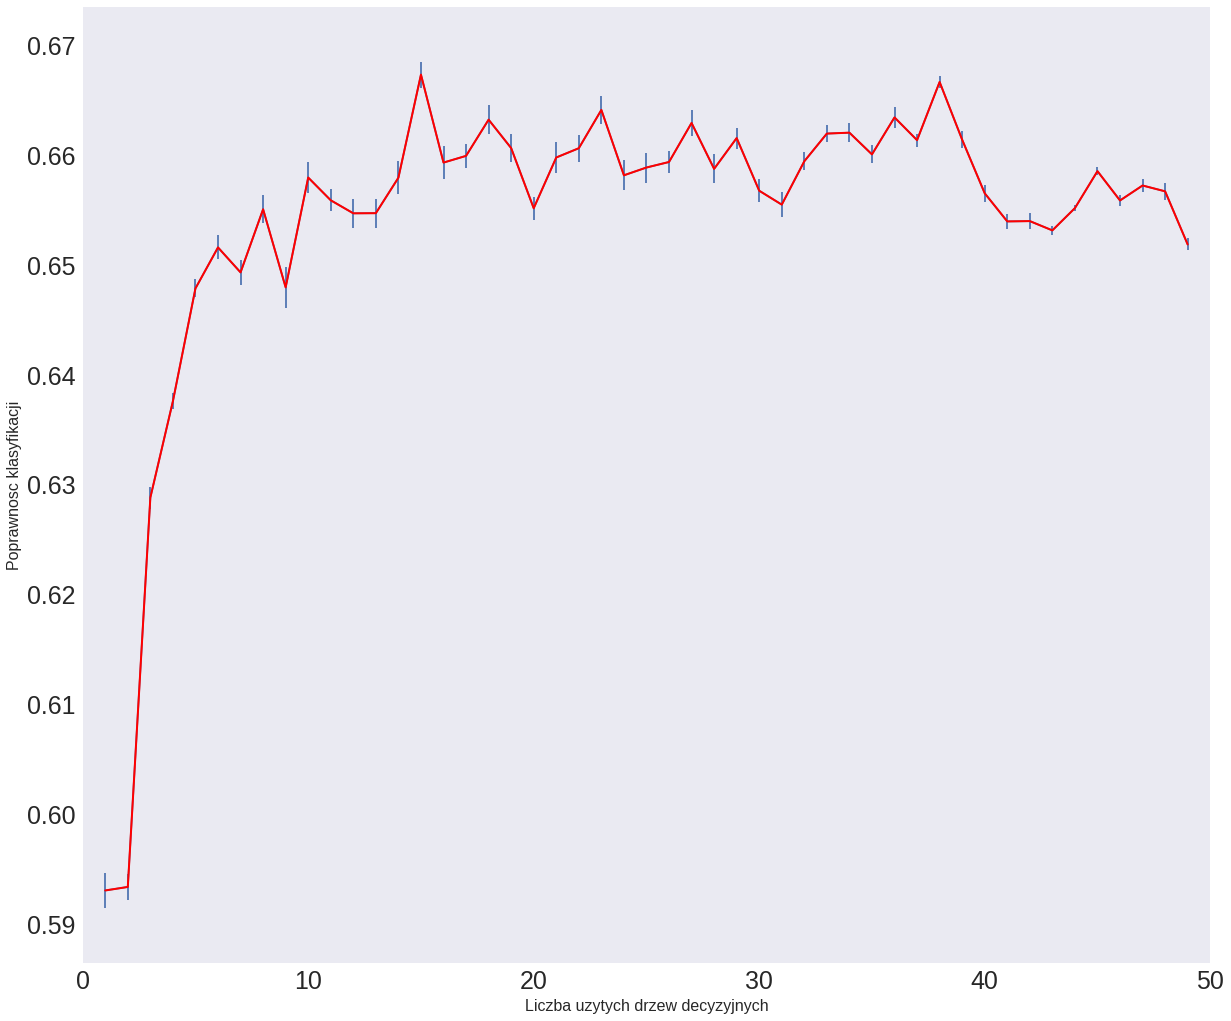

In [86]:
random_forest_score(n_samples=1500, centers=9, max_trees=50)

### Popularność
* lasy drzew losowych są __bardzo__ popularne
  * proste w użyciu
    * wymagają bardzo niewiele dopasowywania dla rozwiązania zadanego problemu
  * stosunkowo szybkie w uczeniu
    * potrzebują jednak zbudowania __dużej__ liczby pojedynczych drzew
* obecnie są jednymi z najdokładniejszych klasyfikatorów
  * jednak wiele algorytmów osiąga lepsze rezultaty
  
  
* jeśli problem ma wiele atrybutów i tylko __niewielki__ procent istotnych
  * wybór atrybutów istotnych staje się coraz rzadsza
  * modele typu boosting zaczynają przeważać
  
* lasy losowe rzadko nadmiernie dopasowują się do danych

* nazwa __random forests__ jest zastrzeżona do komercyjnego wykorzystania przez Salford Systems!

# Określanie przedziałów ufności dla modeli liniowych


#### wykorzystanie błędu standardowego
* model liniowy z funkcjami bazowymi
  * $H$ macierzą $K$ funkcji bazowych $N$ przykładów
  * aproksymacja modelem liniowym daje zestaw paramaterów modelu $\hat{\theta}$
  * kowariancja $\hat{\theta}$ jest określona jako $$var(\hat{\theta})=(H^TH)^{-1}\hat{\sigma}^2$$ gdzie $\hat{\sigma}^2$ jest błędem kwadratowym aproksymacji
  * dla każdego przykładu błąd standardowy jest określony przez $$\widehat{std}(\hat{y}x)=[h(x)^T(H^TH)^{-1}h(x)]^{1/2}\hat{\sigma}$$
  * przedział $$\hat{y}(x)\pm 1.96 \widehat{std}(\hat{y}(x))$$
  
  
#### wykorzystanie metodologii bootstrap
  * wylosowanie $B=200$ zbiorów boostrap
  * wzięcie jako przedziału 5-tej najmniejszej i 5-tej najwiekszej wartości daje przedział 95 procentowej ufności
  
  

In [20]:
def draw_bootstrap(X, y):
    select = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
    return X[select, :], y[select]

In [21]:
class Gaussians_data():
    def __init__(self, n_gaussians=5):
        self.n_gaussians = n_gaussians
        self.basis_mu = np.zeros((n_gaussians))
        self.basis_sigma = 1.
    def gaussian_basis(self, x, mu, sigma):
        return np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    def fit_transform(self, X):
        # TODO rozszerzyć do więcej niż jednego wymiaru
        mm = np.zeros((2, 1))
        mm[0, 0] = np.min(X)
        mm[1, 0] = np.max(X)
        ext = (mm[1, 0] - mm[0, 0]) / float(self.n_gaussians)
        mm[0, 0] -= ext /2.; mm[1, 0] += ext / 2.
        self.basis_mu = np.linspace(mm[0, 0], mm[1, 0], self.n_gaussians + 2)[1:-1]
        self.basis_sigma = 1. * (self.basis_mu[1] - self.basis_mu[0])
        # transformacja danych
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X, self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def transform(self, X):
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X[:, 0], self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def get_params(self):
        return self.basis_mu, self.basis_sigma

In [22]:
def bootstrap_inference(n_gaussians=5, n_exmpl=100, std=0.1, bootstrap_runs=10):
    left = -1.0; right = 1.0
    X = np.array(sorted(np.random.uniform(left, right, size=n_exmpl))).reshape((n_exmpl, 1))
    noise = np.random.normal(loc=0.0, scale=std, size=n_exmpl)
    y = 2. * X ** 4 + 6.5 * X ** 3 + 0.5 * X ** 2 - 4. * X 
    y = y + noise.reshape((n_exmpl, 1))
    y = y.reshape((n_exmpl, ))
    fig, ax = plt.subplots(3, 1, figsize=(16, 22))
    ax[0].plot(X, y, '.', ms=12, c='red')
    gd = Gaussians_data()
    X_trans = gd.fit_transform(X)
    lr = SGDRegressor(n_iter=10000)
    lr.fit(X_trans, y)
    x_test = np.linspace(left, right, n_exmpl).reshape((n_exmpl, 1))
    x_test_trans = gd.transform(x_test)
    y_lr_pred = lr.predict(x_test_trans)
    ax[0].plot(x_test, y_lr_pred, c='black', lw=4)
    # oblicz 95% granice zaufania
    xtxi = np.linalg.inv(np.dot(X_trans.T, X_trans))
    y_pred = lr.predict(X_trans)
    var = np.sum((y - y_pred) ** 2) / y.shape[0]
    se = np.zeros((y.shape[0]))
    varsqrt = np.sqrt(var)
    # oblicz błędy standardowe dla przykładów
    for i in range(y.shape[0]):
        se[i] = np.sqrt(np.dot(np.dot(X_trans[i].T, xtxi), X_trans[i])) * varsqrt
    upper = y_pred + 1.96 * se
    lower = y_pred - 1.96 * se
    ax[0].plot(X, upper, '--k', lw=2)
    ax[0].plot(X, lower, '--k', lw=2)
    ax[0].set_xlim([left, right])
    
    # wylosuj zbiory bootstrap i oblicz dla nich predykcje
    ax[1].plot(X, y, '.', ms=12, c='red')
    res = np.zeros((bootstrap_runs, y.shape[0]))
    for b in range(bootstrap_runs):
        X_b, y_b = draw_bootstrap(X, y)
        gd = Gaussians_data(n_gaussians=n_gaussians)
        X_b_trans = gd.fit_transform(X_b)
        lrg = SGDRegressor(n_iter=5000)
        lrg.fit(X_b_trans, y_b)
        X_trans = gd.transform(X)
        res[b, :] = lrg.predict(X_trans)
        X_test_trans = gd.transform(x_test)
        y_test_lrg_pred = lrg.predict(X_test_trans)
        # res[b, :] = y_test_lrg_pred
        ax[1].plot(x_test, y_test_lrg_pred, alpha=0.5)
    ax[1].set_xlim([left, right])
    # wybierając 5-tą najwyższą i 5-tą najniższą wartość określamy 95%
    # granice zaufania
    res_sorted = np.sort(res, axis=0)
    ax[2].plot(X, y, '.', ms=12, c='red')
    shift = int(np.floor(0.05 * bootstrap_runs / 2))
    ax[2].plot(X, res_sorted[shift - 1, :], '--k', lw=2)
    ax[2].plot(X, res_sorted[bootstrap_runs - shift], '--k', lw=2)
    # ax[2].fill_between(X, res_sorted[4, :], res_sorted[bootstrap_runs - 5], alpha=0.25)
    ax[2].set_xlim([left, right])
    # rozwiązanie bootstrap aggregation (bagging)
    bag = np.mean(res, axis=0)
    ax[2].plot(X, bag, c='red', lw=4, label='Bagging')
    ax[2].plot(x_test, y_lr_pred, '--', c='black', lw=4, label='Oryginalne')
    ax[2].legend(loc=0)
    fig.tight_layout()

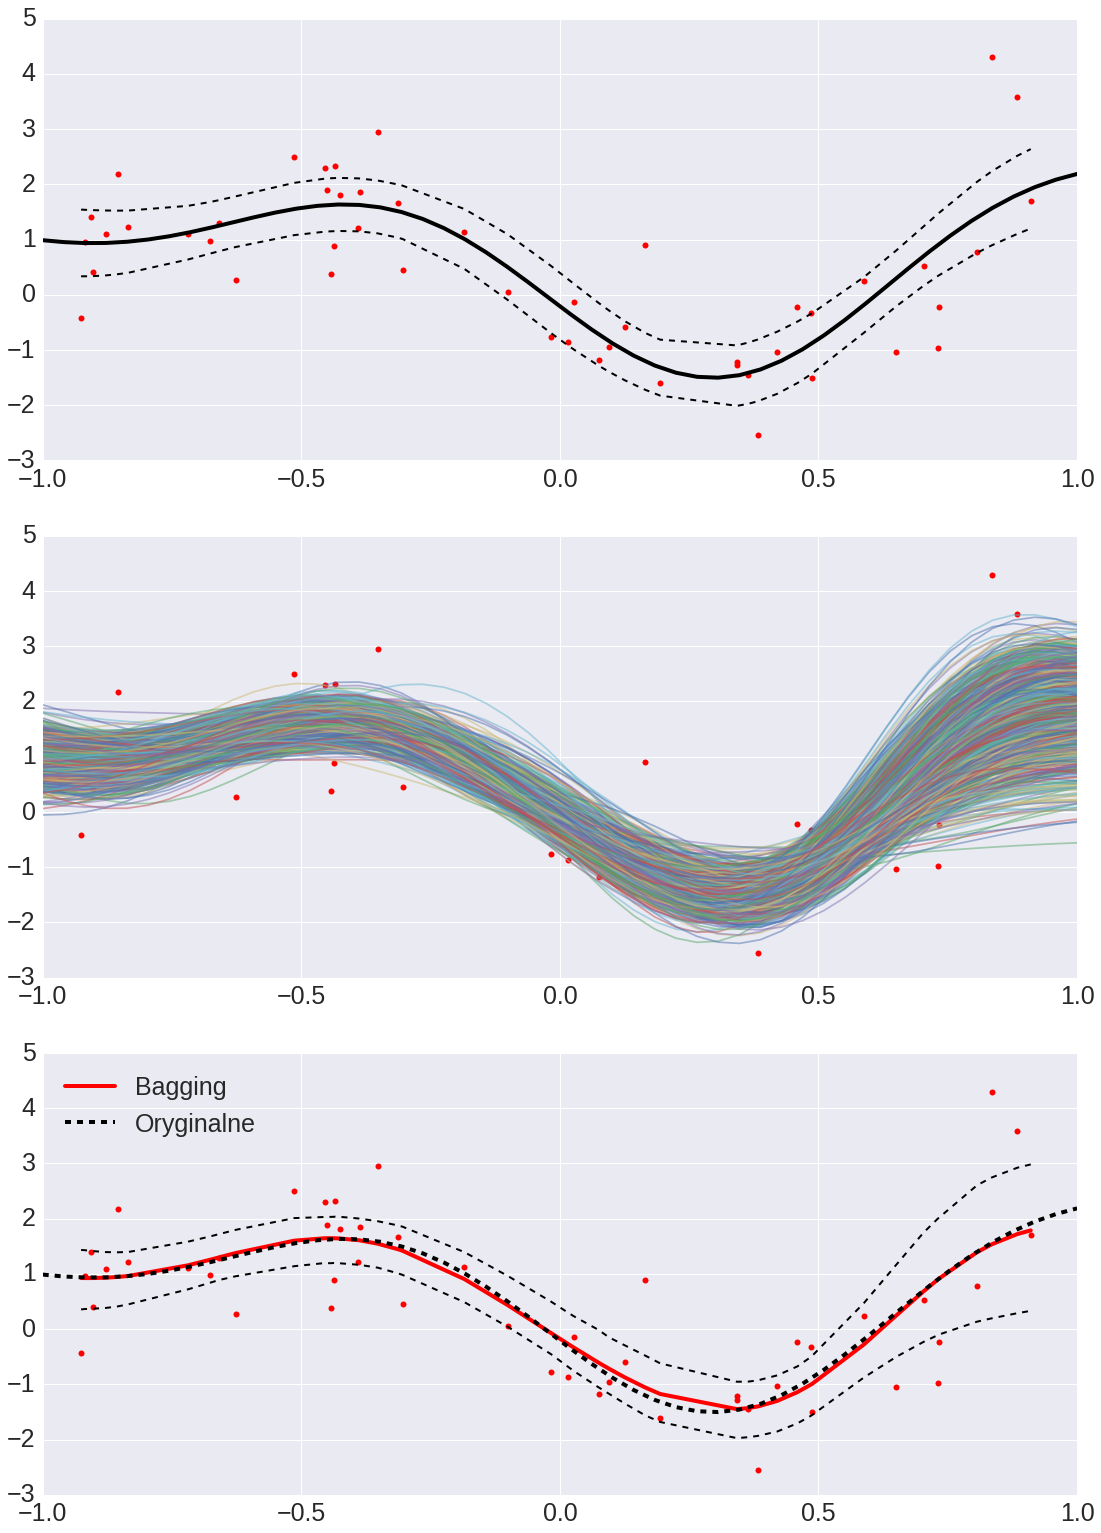

In [90]:
bootstrap_inference(n_gaussians=7, n_exmpl=50, std=0.75, bootstrap_runs=1000)

# Uśrednianie modeli


* bagging często pozwala na zredukowanie błędu kwadratowego
* mamy też inne sposoby __skladania__ modeli
  * mamy $K$ modeli $\mathcal{M}_k\;k=1,\dots,K$ dla zbioru danych $D$
  * modele mogą być 
    * __tego samego typu__ ale z __różnymi__ parametrami
    * __różnych typów__ dla __tego samego__ zadania
  * niech $z$ będzie jakąś interesującą nas wartością (predykcją w punkcie x, statystyką, etc.)
  $$P(z|D)=\sum_{k=1}^K P(z|\mathcal{M}_k,D)P(\mathcal{M}_k|D)$$
  z wartością oczekiwaną
  $$E(z|D)=\sum_{k=1}^K E(z|\mathcal{M}_k,D)P(\mathcal{M}_k|D)$$


  * predykcja jest __ważoną__ średnią pojedynczych predykcji __proporcjonalną__ do prawdopodobieństwa każdego modelu (zależnego od zbioru danych, _posterior_)
  
 
 
 
## Komitety maszyn
* __Komitety maszyn__ biorą __prostą średnią__ (z równym prawdopodobieństwem każdego modelu)
* możemy użyć jakiejś miary oceniającej prawdopodobieństwo/jakość modelu
  * preferując modele mniej złożone można np. uzyc miary __BIC__ (__Bayesian Information Criterion__)
  $$BIC=\frac{N}{\sigma_{\epsilon}^2}\sum_i(y_i-\hat{f}(x_i))^2+(\log N)d$$
  gdzie $d$ jest liczbą __parametrów__ modelu (np. liczbą funkcji bazowych)
* uśrednianie modeli (w każdym razie dla regresji) __nigdy__ nie pogarsza wyników, w każdym razie dla estymacji na pełnym rozkładzie danych
  * ten nie jest dostępny...
  * zwykle zabezpiecza przed złym łączeniem wzięcie pod uwagę złożoności modeli
* dla modeli klasyfikacji konieczne jest, by __nie__ uśredniać modeli __złych__ (gorszych od losowych)
  * pojęcie __modeli słabych__
 

# Modele addytywne


* __modele addytywne__ są zdefiniowane jako
$$E(Y\mid X_1,\dots,X_L)=c+f_1(X_1)+f_2(X_2)+\dots+f_l(X_L)$$
  * $X_j$ są zmiennymi wyjaśniającymi (atrybutami)
  
* regresja logistyczna dla problemu binarnego ma postać
$$\log\left(\frac{y(X)}{1-y(X)}\right)=c+\theta_1X_1+\dots+\theta_L X_L,$$
gdzie $y(X)=P(Y=1|X)$
* __addytywna__ regresja logistyczna będzie miała postać
$$\log\left(\frac{y(X)}{1-y(X)}\right)=c+f_1(X_1)+\dots+f_L(X_L)$$


* model addytywny ma postać $$Y=c+\sum_{l=1}^Lf_l(X_j)+\epsilon,$$
gdzie $\epsilon$ jest szumem

# Boosting
* czy możliwe jest połączenie wielu _słabych_ klasyfikatorów bazowych dla utworzenia modelu o dobrej zdolności predykcji?
    * __słaby klasyfikator__ to taki, którego oczekiwany błąd jest __niewiele lepszy__ od klasyfikatora losowego
* niech $G()$ będzie binarnym klasyfikatorem i 
$$err=\frac{1}{N}\sum_{i=1}^NI(y_i\neq G(x_i)$$
będzie jego błędem nauczania


* __Boosting__ buduje sekwencję $G_k(x)$ słabych klasyfikatorów do cały czas modyfikowanych danych dodając końcową predykcję
$$\boxed{
G(x)=sign\left(\sum_{k=1}^K\alpha_kG_k(x)\right)
\;}$$
  * $\alpha_k$ są wagami słabych klasyfikatorów odpowiadającymi ich __dokładności__
  * zbiory danych są modyfikowane tak, by __skupić uczenie__ na przykładach trudniejszych
    * uczenie przez modyfikację rozkładu danych
  * modele bazowe stają się __ekspertami__ dla pewnych podobszarów danych

## algorytm uczenia AdaBoost.M1

1. inicjalizacja __wag przykładów__ na $w_i=1/N$
2. for $k$ in range($K$):
  1. zbuduj klasyfikator $G_k(x)$ dla danych z wagami $w_i$
    * przykłady w trakcie uczenia są __losowane__ zgodnie z rozkładem wag $w$
  2. oblicz aktualny błąd uczący $G_k()$ $$err_k=\frac{\sum_{i=1}^Nw_iI(y_i\neq G_k(x_i))}{\sum_{i=1}^Nw_i}$$
  3. oblicz współczynnik istotności $\alpha_k$ modelu 
  $$\alpha_k=\ln\left(\frac{1-err_k}{err_k}\right)$$ jako funkcję __logit__
  4. zmodyfikuj wagi przykładów $$w_i=w_i\cdot\exp(\alpha_k\cdot I(y_i\neq G_k(x_i)))$$
    * jeśli $x_i$ był __źle rozpoznawany__ przez $G_k()$, to waga $x_i$ jest zwiększana
    * jeśli $x_i$ był poprawnie rozpoznawany, to waga jest zmniejszana
    * wektor wag jest znormalizowany
3. zwróć model końcowy $$G(x)=sign\left[\sum_{k=1}^K\alpha_k G_k(x)\right]$$


* nawet bardzo słabe klasyfikatory mogą dać do wysoką skuteczność modelu
* AdaBoost jest modelem 
  * __addytywnym__
  * __krokowym__ bo w każdym etapie optymalizuje tylko ze względu jedną parę parametrów, tj. $\alpha_k, G_k$ 
  * __zachłannym__ bo nie __nie zmienia__ poprzednich $\alpha_j, G_j;\;\;j=1,\dots,k-1$
  * lepszy byłby model optymalizujący wszystkie $G_k$ 
    * zbyt złożony problem optymalizacyjny

In [23]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [24]:
def adaboost(n_samples=500):
    Xa, ya = make_gaussian_quantiles(mean=(1, 1), cov=1.5, n_samples=n_samples, 
                                     n_features=2, n_classes=2)
    Xb, yb = make_gaussian_quantiles(mean=(2, 3), cov=2.0, n_samples=n_samples, 
                                     n_features=2, n_classes=2)
    X = np.concatenate((Xa, Xb))
    y = np.concatenate((ya, -yb +1))
    fc = (y > 0)
    sc = (y < 1)
    fig, ax = plt.subplots(figsize=(18, 16))
    ax.plot(X[fc, 0], X[fc, 1], '.', ms=14)    
    ax.plot(X[sc, 0], X[sc, 1], '.', ms=14)
    
    tree = DecisionTreeClassifier(max_depth=1)
    # dummy = DummyClassifier(strategy='prior')
    adab = AdaBoostClassifier(tree, n_estimators=200)
    adab.fit(X, y)
    
    h = 0.01
    ext = 0.25
    x_min, x_max = X[:, 0].min() - ext, X[:, 0].max() + ext
    y_min, y_max = X[:, 1].min() - ext, X[:, 1].max() + ext
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = adab.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

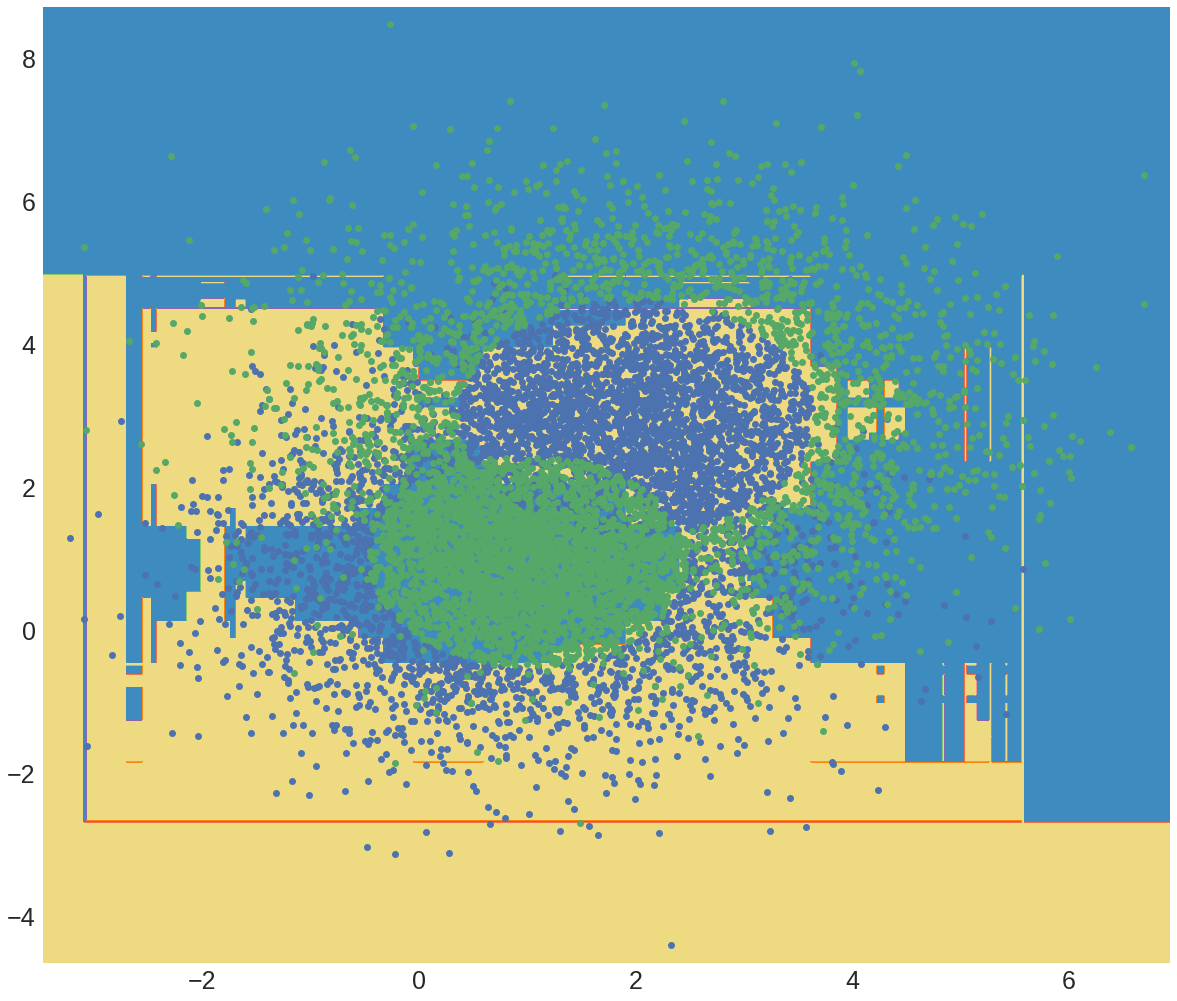

In [25]:
adaboost(n_samples=5000)